In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as mplplot
import dateutil.parser
import pickle
import sys
import regex
import copy
import itertools
import gc
import os
from collections import Counter

In [2]:
verbose = True
if verbose :
    import pprint
    from IPython.core.display import display
    pprinter = pprint.PrettyPrinter(indent=4)

In [3]:
%matplotlib inline
#%matplotlib notebook

## Globally relevant variables

In [4]:
sampleDataFileName = 'decoding-the-civil-war-classifications-2.csv'
subjectDataFileName = 'decoding-the-civil-war-subjects.csv'
aggregatedDataFileName = 'decoding-the-civil-war-aggregated.txt'
aggregatedDataCsvFileName = 'decoding-the-civil-war-consensus-linewise.csv'
aggregatedDataSubjectWiseCsvFileName = 'decoding-the-civil-war-consensus-subjectwise.csv'
identifiedLineFilePath = 'dataWithLineIDs_subset.pkl'
liveDate = dateutil.parser.parse("2016-06-20T00:00:00.00Z")
saveIdentifiedLineDetails = False

## Classes to encapsulate single lines of text and multiple lines of text

In [5]:
class TextLine() :
    
    def __init__(self, x1, y1, x2, y2, text) :
        self.coords = {'start' : {'x' : x1, 'y' : y1}, 'end' : {'x' : x2, 'y' : y2}}
        self.text = text
        self.words = text.split()
        self.numWords = len(self.words)
        
    def __str__(self) :
        return str(self.text) + " @ ((" + str(self.coords['start']['x']) + ", " + str(self.coords['start']['y']) + "), (" + str(self.coords['end']['x']) + ", " + str(self.coords['end']['y']) + "))"
    
    def getStart(self) :
        return self.coords['start']
    
    def getEnd(self) :
        return self.coords['end']
    
    def getText(self) :
        return str(self.text)
    
    def getCoords(self) :
        return self.coords
    
    def getWords(self) :
        return self.words

In [6]:
class TelegramLines() :
    
    def __init__(self) :
        self.textLines = []
        
    def __str__(self) :
        return "\n".join([textLine.__str__() for textLine in self.textLines])
        
    def addLine(self, textLine) :
        self.textLines.append(textLine)
    
    def getLines(self) :
        return self.textLines
    
    def getNumLines(self) :
        return len(self.textLines)

In [7]:
class LineMatcher() :
    
    def __init__(self, _yTolerance, _xTolerance = None) :
        self.currentCoords = (-1,-1,-1,-1)
        self.yTolerance = _yTolerance
        self.xTolerance = _xTolerance
    
    def compare(self, lineCoords) :
        different = np.abs(lineCoords[1] - self.currentCoords[1]) > self.yTolerance or np.abs(lineCoords[3] - self.currentCoords[3]) > self.yTolerance
        if not different and self.xTolerance is not None :
            different = different and (np.abs(lineCoords[0] - self.currentCoords[0]) > self.xTolerance or np.abs(lineCoords[2] - self.currentCoords[2]) > self.xTolerance)
        if different :
            self.setCurrentCoords(lineCoords)
            return True
        else :
            return False
    
    def setCurrentCoords(self, _newCoords) :
        self.currentCoords = _newCoords

In [8]:
class MetaTagState():
    
    def __init__(self) :
        self.setTags = {}
        
    def setTag(self, tag, start, end) :
        if tag in self.setTags :
            self.setTags[tag].append((start, end))
        else :
            self.setTags.update({tag : [(start, end)]})
        return self.setTags[tag]
    
    def reset(self) :
        self.setTags = {}
    
    def getSetTags(self) :
        return self.setTags

In [9]:
class StatefulWord():
    
    def __init__(self, _word, _span, _tagStates, _sentence) :
        self.word = _word
        self.tagStates = _tagStates
        self.sentence = _sentence
        self.span = _span
        
    def __hash__(self) :
        return self.word.__hash__()
    
    def __eq__(self, other) :
        return self.word == other.word   
    
    def __str__(self) :
        return 'SW:' + str(self.word) + ' ' + str(self.tagStates)
    
    def __repr__(self) :
        return 'SW:' + str(self.word)
    
    def asTuple(self) :
        return (self.word, self.span, self.tagStates, self.sentence)

## Parse the downloaded subject data into data structures for processing

In [10]:
subject_data = []
subjectColumns = ['subject_id', 'huntington_id', 'url', 'retired_in_workflow']
with open(subjectDataFileName) as csvfile :
    parsedSubjectCsv = csv.DictReader(csvfile)
    numPrinted = 0
    for subject in parsedSubjectCsv :
        parsedLocations = json.loads(subject['locations'])
        parsedMetaData = json.loads(subject['metadata'])
        if 'hdl_id' not in parsedMetaData :
            continue
        subject_data.append({'subject_id': int(subject['subject_id']), 'huntington_id' : parsedMetaData['hdl_id'], 'url' : parsedLocations['0'], 'retired' : len(json.loads(subject['retired_in_workflow'])) > 0})
subjectsFrame = pd.DataFrame.from_records(subject_data, index = 'subject_id')
display(subjectsFrame)

,huntington_id,retired,url
subject_id,,,
1959268,mssEC_01_001,False,https://panoptes-uploads.zooniverse.org/produc...
1959269,mssEC_01_002,True,https://panoptes-uploads.zooniverse.org/produc...
1959270,mssEC_01_003,False,https://panoptes-uploads.zooniverse.org/produc...
1959271,mssEC_01_004,False,https://panoptes-uploads.zooniverse.org/produc...
1959272,mssEC_01_005,False,https://panoptes-uploads.zooniverse.org/produc...
1959273,mssEC_01_006,False,https://panoptes-uploads.zooniverse.org/produc...
1959274,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959275,mssEC_01_008,False,https://panoptes-uploads.zooniverse.org/produc...
1959276,mssEC_01_009,False,https://panoptes-uploads.zooniverse.org/produc...


## Parse the downloaded classification data into data structures for processing

In [11]:
telegrams = {}

with open(sampleDataFileName) as csvfile :
    parsedCsv = csv.DictReader(csvfile)
    nTelegramsParsed = 0
    for recordIndex, record in enumerate(parsedCsv) :
        done = False
        recordIsTelegram = True
        
        # check the date that the classification was made
        parsedMetadata = json.loads(record["metadata"])
        parsedDate = dateutil.parser.parse(parsedMetadata['started_at'])
        # skip "testing" data before the site went live
        
        if parsedDate < liveDate :
            continue
        
        # parse the annotations and the subject data
        parsedAnnotations = json.loads(record["annotations"])
        parsedSubjectData = json.loads(record["subject_data"])
        
        # initialize container for transcribed lines
        transcribedLines = TelegramLines()
        
        #loop over tasks in the annotation
        for task in parsedAnnotations :
            # Check if the current record is for a telegram (tasks may be stored out of order, so
            # some tasks may be processed before non-telegrams are caught - inefficient but unavoidable?)
            if task['task'] == "T1" and not task['value'].startswith("Telegram") :
                recordIsTelegram = False
                break
            
            # Process transcriptions of text lines
            if task['task'].startswith("T12") and len(task['value']) > 0 :
                # process the lines that were transcribed for this task
                for taskValueItem in task['value']:
                    transcribedLine = TextLine(taskValueItem['x1'], 
                                               taskValueItem['y1'], 
                                               taskValueItem['x2'], 
                                               taskValueItem['y2'],
                                               taskValueItem['details'][0]['value'])
                    transcribedLines.addLine(transcribedLine)
            
        # if the transcribed lines of a telegram have been processed then update the 
        # list of independent transcriptions for this subject
        if recordIsTelegram :
            nTelegramsParsed += 1
            if int(record['subject_ids']) in telegrams :
                telegrams[int(record['subject_ids'])].append((recordIndex, transcribedLines))
            else :
                telegrams.update({int(record['subject_ids']) : [(recordIndex, transcribedLines)]})     

### Print some summary information about the parsed data

In [12]:
print(len(telegrams), nTelegramsParsed)

5826 39192


## Cast parsed data into structures that enable "straightfoward" aggregation analysis

In [13]:
transcriptionLineStats = {}
transcriptionLineDetails = []
# loop over distinct subjects (currently individual telegram-type pages, codebook handling to be implemented)
for key, transcriptions in telegrams.items() :
    totalLines = 0
    maxLines = 0
    minLines = sys.maxsize
    # loop over individual transcriptions of the subject
    for transcriptionData in transcriptions :
        transcription = transcriptionData[1]
        transcriptionIndex = transcriptionData[0]
        # process overall transcription statistics for this subject
        numLines = transcription.getNumLines()
        totalLines += numLines 
        maxLines = numLines if numLines > maxLines else maxLines
        minLines = numLines if numLines < minLines else minLines
        # process the lines of the individual transcriptions of a subject
        for textLine in transcription.getLines() :
            # Add a dictionary describing the current line
            lineDescription = {'subjectKey' : key,
                               'transcriptionIndex' : transcriptionIndex,
                               'numLines' : numLines,
                               'x1' : textLine.getStart()['x'],
                               'y1' : textLine.getStart()['y'],
                               'x2' : textLine.getEnd()['x'],
                               'y2' : textLine.getEnd()['y'], 
                              'words' : textLine.getWords()}
            transcriptionLineDetails.append(lineDescription)
    transcriptionLineStats.update({key: {'minLines': minLines, 'maxLines':maxLines, 'meanLines':totalLines/float(len(transcriptions))}})

transcriptionLineDetailsFrame = pd.DataFrame(data=transcriptionLineDetails)
transcriptionLineDetailsIndex = pd.MultiIndex.from_arrays([transcriptionLineDetailsFrame['subjectKey'],
                                                           transcriptionLineDetailsFrame['y1'],
                                                           transcriptionLineDetailsFrame['y2'],
                                                           transcriptionLineDetailsFrame['x1'],
                                                           transcriptionLineDetailsFrame['x2']])
transcriptionLineDetailsFrame = transcriptionLineDetailsFrame.set_index(transcriptionLineDetailsIndex)
transcriptionLineDetailsFrame = transcriptionLineDetailsFrame.sort_index(level=0, sort_remaining=True)
display(transcriptionLineDetailsFrame)


numLines  \
subjectKey y1          y2          x1         x2                      
1959274    232.434772  232.434772  717.137204 1149.749733        27   
           233.158520  230.508991  698.955184 1124.204537        26   
           233.202575  230.101682  694.689762 1110.209471        26   
           234.565674  234.565674  694.741640 1238.234359         1   
           238.021980  233.377649  689.587430 1163.309237        27   
           238.591850  236.397902  695.665494 1104.836796        27   
           239.219186  232.589555  699.863693 1126.367306        26   
           241.769488  241.769488  195.544735 1279.201965        27   
           289.240312  290.448940  214.436611 1200.503158        27   
           294.915039  290.270707  181.033136 1238.779623        27   
           295.422443  292.772914  186.271385 1183.818932        26   
           296.770890  286.491428  178.391019 1246.509234        26   
           301.314161  292.364236  175.300068 1158.901696        26   
           306.604239  291.246603  175.699817 1193.691691        27   
           310.657233  300.059118  192.895207 1296.423901        27   
           352.387309  343.113958  192.895207 1238.134270        26   
           354.041841  346.537679  182.745326 1235.203999        26   
           354.118721  346.958781  181.565046 1225.131469        26   
           354.506251  343.628595  203.560877 1259.715488        27   
           359.935677  346.002683  184.516385 1265.484529        27   
           364.743862  347.192278  184.475609 1235.376703        27   
           364.972570  363.647805  190.245678 1281.851493        27   
           404.694935  395.314732  178.993245 1212.691514        26   
           406.103594  396.224113  198.816272 1193.174750        27   
           406.702646  401.403588  183.621856 1206.339926        26   
           407.818274  392.603401  177.985058 1199.176558        26   
           408.701156  392.445996  178.710971 1256.195866        27   
           412.664085  407.365028  186.271385 1264.629557        27   
           414.107693  404.234927  188.863505 1248.540391        27   
           456.013089  447.181558  176.665052 1274.334850        26   
...                                                             ...   
2880574    1031.660732 1023.412160 169.802441 1348.167701        18   
           1032.528014 1019.649464 177.782562 1343.876893        18   
           1035.480512 1038.662852 146.812339 557.335300         20   
           1041.248371 1029.610363 184.733708 583.682567         20   
           1054.542346 1030.947863 162.063156 1360.138679        18   
           1093.454541 1083.609143 169.083050 1354.222892        17   
           1094.910728 1078.999026 174.392709 1334.358749        20   
           1096.470944 1082.330534 180.407728 1379.983563        18   
           1099.262318 1087.554546 205.881220 1353.243112        18   
           1100.420509 1082.069244 181.725227 1350.963046        18   
           1101.741159 1083.123987 203.349110 1355.968850        20   
           1143.605643 1140.070541 183.942824 1377.626832        18   
           1149.010514 1128.325302 210.989717 1355.044015        20   
           1150.776518 1146.093409 224.613659 1333.339896        18   
           1152.916681 1144.768308 211.479180 1361.796025        20   
           1154.988280 1136.528159 192.465871 1373.913689        17   
           1158.095914 1139.744649 192.211665 1319.503733        18   
           1209.919941 1194.792298 207.989882 1372.263919        20   
           1213.129325 1195.453813 191.013016 1362.308084        18   
           1214.060670 1194.369873 199.849920 1348.069518        17   
           1215.839662 1211.066151 209.398543 1351.861666        20   
           1218.392928 1201.352468 194.833274 1337.854999        18   
           1218.681600 1203.461496 202.368888 1333.339896        18   
           1252.015452 1252.015452 885.070154 1218.547522        18   
           1

## Group transcriptions of individual lines according to spatial proximity
**Note** that a very important parameter for this process is the pixel tolerance that specifies the allowed disparity between corresponding *y* coordinates of separately marked annotated lines

In [14]:
if saveIdentifiedLineDetails :
    transcriptionLineDetailsFrame['bestLineIndex'] = pd.Series(np.zeros_like(transcriptionLineDetailsFrame['subjectKey']),
                                                               index=transcriptionLineDetailsFrame.index)
    # iterate over rows in sorted, grouped dataset and insert the best line index
    bestLineIndex = -1
    currentSubject = -1
    numSubjectsProcessed = 0
    # line matcher with 40 pixel tolerance for y coordinates of lines that are considered to be the same
    lineMatcher = LineMatcher(40)
    for index, row in transcriptionLineDetailsFrame.iterrows() :
        # if this is a new subject, reset the line index
        if currentSubject != index[0] :
            bestLineIndex = -1
            currentSubject = index[0]
            numSubjectsProcessed += 1
            if numSubjectsProcessed % 100 == 0 :
                print ('Processed {0} subjects...'.format(numSubjectsProcessed))
        
        # if the line coordinates do not match within tolerance, then increment the line index
        if lineMatcher.compare((index[3], index[1], index[4], index[2])) :
            bestLineIndex +=1
        
        # update the dataframe with the best line index
        transcriptionLineDetailsFrame.ix[index, 'bestLineIndex'] = bestLineIndex
else :
    identifiedLineFile = open(identifiedLineFilePath, 'rb')
    transcriptionLineDetailsFrame = pickle.load(identifiedLineFile)
    identifiedLineFile.close()
display(transcriptionLineDetailsFrame)
pprinter.pprint(transcriptionLineStats)

numLines  \
subjectKey y1          y2          x1         x2                      
1959274    232.434772  232.434772  717.137204 1149.749733        27   
           233.158520  230.508991  698.955184 1124.204537        26   
           233.202575  230.101682  694.689762 1110.209471        26   
           234.565674  234.565674  694.741640 1238.234359         1   
           238.021980  233.377649  689.587430 1163.309237        27   
           238.591850  236.397902  695.665494 1104.836796        27   
           239.219186  232.589555  699.863693 1126.367306        26   
           241.769488  241.769488  195.544735 1279.201965        27   
           289.240312  290.448940  214.436611 1200.503158        27   
           294.915039  290.270707  181.033136 1238.779623        27   
           295.422443  292.772914  186.271385 1183.818932        26   
           296.770890  286.491428  178.391019 1246.509234        26   
           301.314161  292.364236  175.300068 1158.901696        26   
           306.604239  291.246603  175.699817 1193.691691        27   
           310.657233  300.059118  192.895207 1296.423901        27   
           352.387309  343.113958  192.895207 1238.134270        26   
           354.041841  346.537679  182.745326 1235.203999        26   
           354.118721  346.958781  181.565046 1225.131469        26   
           354.506251  343.628595  203.560877 1259.715488        27   
           359.935677  346.002683  184.516385 1265.484529        27   
           364.743862  347.192278  184.475609 1235.376703        27   
           364.972570  363.647805  190.245678 1281.851493        27   
           404.694935  395.314732  178.993245 1212.691514        26   
           406.103594  396.224113  198.816272 1193.174750        27   
           406.702646  401.403588  183.621856 1206.339926        26   
           407.818274  392.603401  177.985058 1199.176558        26   
           408.701156  392.445996  178.710971 1256.195866        27   
           412.664085  407.365028  186.271385 1264.629557        27   
           414.107693  404.234927  188.863505 1248.540391        27   
           456.013089  447.181558  176.665052 1274.334850        26   
...                                                             ...   
2880574    1031.660732 1023.412160 169.802441 1348.167701        18   
           1032.528014 1019.649464 177.782562 1343.876893        18   
           1035.480512 1038.662852 146.812339 557.335300         20   
           1041.248371 1029.610363 184.733708 583.682567         20   
           1054.542346 1030.947863 162.063156 1360.138679        18   
           1093.454541 1083.609143 169.083050 1354.222892        17   
           1094.910728 1078.999026 174.392709 1334.358749        20   
           1096.470944 1082.330534 180.407728 1379.983563        18   
           1099.262318 1087.554546 205.881220 1353.243112        18   
           1100.420509 1082.069244 181.725227 1350.963046        18   
           1101.741159 1083.123987 203.349110 1355.968850        20   
           1143.605643 1140.070541 183.942824 1377.626832        18   
           1149.010514 1128.325302 210.989717 1355.044015        20   
           1150.776518 1146.093409 224.613659 1333.339896        18   
           1152.916681 1144.768308 211.479180 1361.796025        20   
           1154.988280 1136.528159 192.465871 1373.913689        17   
           1158.095914 1139.744649 192.211665 1319.503733        18   
           1209.919941 1194.792298 207.989882 1372.263919        20   
           1213.129325 1195.453813 191.013016 1362.308084        18   
           1214.060670 1194.369873 199.849920 1348.069518        17   
           1215.839662 1211.066151 209.398543 1351.861666        20   
           1218.392928 1201.352468 194.833274 1337.854999        18   
           1218.681600 1203.461496 202.368888 1333.339896        18   
           1252.015452 1252.015452 885.070154 1218.547522        18   
           1

{   1959274: {'maxLines': 27, 'meanLines': 18.7, 'minLines': 0},
    1959275: {'maxLines': 26, 'meanLines': 17.333333333333332, 'minLines': 1},
    1959277: {'maxLines': 34, 'meanLines': 22.4, 'minLines': 0},
    1959278: {'maxLines': 34, 'meanLines': 28.6, 'minLines': 1},
    1959279: {'maxLines': 29, 'meanLines': 28.2, 'minLines': 28},
    1959280: {'maxLines': 36, 'meanLines': 29.0, 'minLines': 1},
    1959281: {'maxLines': 12, 'meanLines': 4.333333333333333, 'minLines': 0},
    1959286: {'maxLines': 41, 'meanLines': 30.3, 'minLines': 1},
    1959288: {'maxLines': 36, 'meanLines': 29.333333333333332, 'minLines': 0},
    1959290: {'maxLines': 31, 'meanLines': 18.555555555555557, 'minLines': 0},
    1959291: {'maxLines': 26, 'meanLines': 16.333333333333332, 'minLines': 0},
    1959292: {'maxLines': 27, 'meanLines': 21.555555555555557, 'minLines': 4},
    1959293: {'maxLines': 29, 'meanLines': 20.0, 'minLines': 0},
    1959295: {'maxLines': 31, 'meanLines': 17.444444444444443, 'minLine

## Serialize the processed data at this stage
The previous step is time consuming so save the data.

In [15]:
if saveIdentifiedLineDetails :
    transcriptionLineDetailsFrame.to_pickle(identifiedLineFilePath)

## Now aggregate the text of the spatially matched lines
In the process, identify, strip and note any metatags e.g. `[unclear][/unclear]` that surround individual words.

In [16]:
def computeConsensusWordReliability(wordOptions) :
    uniqueWordOptions = list(set(wordOptions))
    #simple logic to return 0 reliability for words with very few consistent transcriptions
    if len(wordOptions) < 2 :
        return -0.25
    
    if (len(wordOptions) < 3 and len(uniqueWordOptions) > 1) :
        return -0.5
    
    # more complicated logic that computes the fraction of transcribed words that equal the
    # consensus
    wordCounter = Counter(wordOptions)
    consensusWord, consensusWordCount = wordCounter.most_common(1)[0]
    return consensusWordCount/float(len(wordOptions))

In [17]:
def aggregateSentences(sentences) :
    metaTagState = MetaTagState()
    
    unclearPattern = r'(\[unclear\]).+?(\[/unclear\])'
    insertionPattern = r'(\[insertion\]).+?(\[/insertion\])'
    deletionPattern = r'(\[deletion\]).+?(\[/deletion\])'
    
    emptyTagPairPattern = r'\[([^/]+?)\]\[/\1\]'
    
    genericStartPattern = r'(\[([^/]+?)\])'
    genericEndPattern = r'(\[/(.+?)\])'
    
    aggregatedSentence = {'reliability': 0.0, 'wordReliabilities' : [], 'words' : []}
    statefulAggregatedSentence = {'reliability': 0.0, 'wordReliabilities' : [], 'words' : []}
    iSentence = 0
    for sentence in sentences :
        
        ##print ('Next Sentence:\n')
        
        # metatag pairs are better described in "sentence coordinates", these can always be mapped to words later
        fullSentence = ' '.join(sentence)
        
        # Remove any empty metatag pairs
        sentenceLength = len(sentence)
        while True :
            fullSentence = regex.sub(emptyTagPairPattern, '', fullSentence)
            if len(fullSentence) == sentenceLength :
                # no further replacement possible
                break
            else :
                sentenceLength = len(fullSentence)
        
        unclearResults = regex.finditer(unclearPattern, fullSentence)

        insertionResults = regex.finditer(insertionPattern, fullSentence)

        deletionResults = regex.finditer(deletionPattern, fullSentence)
        
        for unclearResult in unclearResults :
            '''print ('\nUnclear:\n', sentence, '\nnumgroups (start)', len(list(unclearResult.groups())), 'groups => ', list(unclearResult.groups()))
            for index, match in enumerate(unclearResult.groups()) :
                print (match, unclearResult.start(index+1), unclearResult.end(index+1))
            print ('Tagging unclear between' , unclearResult.end(1), 'and', unclearResult.start(2))'''
            metaTagState.setTag('unclear', unclearResult.end(1), unclearResult.start(2))
        
        for insertionResult in insertionResults :
            '''print ('\nInsertion:\n', sentence, '\nnumgroups (start)', len(list(insertionResult.groups())), 'groups => ', list(insertionResult.groups()))
            for index, match in enumerate(insertionResult.groups()) :
                print (match, insertionResult.start(index+1), insertionResult.end(index+1))'''
            metaTagState.setTag('insertion', insertionResult.end(1), insertionResult.start(2))
 
        for deletionResult in deletionResults :
            '''print ('\nDeletion:\n', sentence, '\nnumgroups (start)', len(list(deletionResult.groups())), 'groups => ', list(deletionResult.groups()))
            for index, match in enumerate(deletionResult.groups()) :
                print (match, deletionResult.start(index+1), deletionResult.end(index+1))'''
            metaTagState.setTag('deletion', deletionResult.end(1), deletionResult.start(2))

        ##print (metaTagState.getSetTags())
        iWord = 0
        sentencePosition = 0
        for word in sentence :
            if (len(aggregatedSentence['words']) < iWord+1) :
                aggregatedSentence['words'].append([])
                statefulAggregatedSentence['words'].append([])
            
            nonMetaWord = regex.sub(genericStartPattern, '', word)
            nonMetaWord = regex.sub(genericEndPattern, '', nonMetaWord)
            if len(nonMetaWord) > 0:
                aggregatedSentence['words'][iWord].append(nonMetaWord)
                statefulAggregatedSentence['words'][iWord].append(StatefulWord(nonMetaWord, (sentencePosition, sentencePosition + len(word)), copy.deepcopy(metaTagState.getSetTags()), sentence))
                # Only increment wordcount if there was actually a word and not just a collection of metatags
                iWord += 1
            sentencePosition += len(word) + 1
        
        metaTagState.reset()
        iSentence += 1
        ## END LOOP OVER TRANSCRIBED SENTENCES ASSOCIATED WITH THIS LINE
    
    for wordOptions, statefulWordOptions in zip(aggregatedSentence['words'], statefulAggregatedSentence['words']) :
        wordOptions.sort(key=Counter(wordOptions).get, reverse=True)
        statefulWordOptions.sort(key=Counter(statefulWordOptions).get, reverse=True)
        # Compute the reliability of each word's consensus transcription
        statefulAggregatedSentence['wordReliabilities'].append(computeConsensusWordReliability(wordOptions))
        # The word reliability can be outside the 0-1 range in special cases, so adjust clamp 
        # those values appropriately
        clampedWordReliability = statefulAggregatedSentence['wordReliabilities'][-1]
        clampedWordReliability = clampedWordReliability if clampedWordReliability >= 0.0 else 0.0
        clampedWordReliability = clampedWordReliability if clampedWordReliability <= 1.0 else 1.0
        
        statefulAggregatedSentence['reliability'] += clampedWordReliability
    try :
        statefulAggregatedSentence['reliability'] /= float(len(statefulAggregatedSentence['words']))
    except Exception as e :
        #print ('Exception on {} : {}'.format(sentence, e))
        statefulAggregatedSentence['reliability'] = 0.0
        
    return statefulAggregatedSentence

In [18]:
transcriptionLineDetailsReIndexed = transcriptionLineDetailsFrame.reset_index(level=[1,2,3,4], drop=True)  
transcriptionLineDetailsReIndexed.set_index('bestLineIndex', append=True, inplace=True)
display(transcriptionLineDetailsReIndexed)

numLines  subjectKey  transcriptionIndex  \
subjectKey bestLineIndex                                             
1959274    0                    27     1959274               16593   
           0                    26     1959274                6789   
           0                    26     1959274                5510   
           0                     1     1959274               10218   
           0                    27     1959274               11142   
           0                    27     1959274               19859   
           0                    26     1959274               18016   
           0                    27     1959274               12139   
           1                    27     1959274               16593   
           1                    27     1959274               11142   
           1                    26     1959274                6789   
           1                    26     1959274                5510   
           1                    26     1959274               18016   
           1                    27     1959274               19859   
           1                    27     1959274               12139   
           2                    26     1959274                6789   
           2                    26     1959274                5510   
           2                    26     1959274               18016   
           2                    27     1959274               16593   
           2                    27     1959274               11142   
           2                    27     1959274               19859   
           2                    27     1959274               12139   
           3                    26     1959274                5510   
           3                    27     1959274               16593   
           3                    26     1959274                6789   
           3                    26     1959274               18016   
           3                    27     1959274               11142   
           3                    27     1959274               12139   
           3                    27     1959274               19859   
           4                    26     1959274                5510   
...                            ...         ...                 ...   
2880574    14                   18     2880574               21865   
           14                   18     2880574               28709   
           15                   20     2880574               24147   
           15                   20     2880574               19847   
           15                   18     2880574               20036   
           16                   17     2880574               25936   
           16                   20     2880574               24147   
           16                   18     2880574               21865   
           16                   18     2880574               28709   
           16                   18     2880574               20036   
           16                   20     2880574               19847   
           17                   18     2880574               21865   
           17                   20     2880574               24147   
           17                   18     2880574               28709   
           17                   20     2880574               19847   
           17                   17     2880574               25936   
           17                   18     2880574               20036   
           18                   20     2880574               19847   
           18                   18     2880574               21865   
           18                   17     2880574               25936   
           18                   20     2880574               24147   
           18                   18     2880574               20036   
           18                   18     2880574               28709   
           19                   18     2880574               21865   
           19                   20  

In [19]:
lineGroupedTranscriptionLineDetails = transcriptionLineDetailsReIndexed.groupby(level=[0, 1]).aggregate({"words" : aggregateSentences, 'subjectKey': lambda x: x.iloc[0], 'y1' : np.mean , 'y2' : np.mean, 'x1' : np.mean, 'x2' : np.mean, 'transcriptionIndex' : lambda x : tuple([xi for xi in x]),'numLines' : lambda x : tuple([xi for xi in x])})

In [20]:
lineGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails.reset_index(level=[1])
lineGroupedTranscriptionLineDetails = pd.merge(lineGroupedTranscriptionLineDetails, subjectsFrame, left_index=True, right_index=True, how='left')
display (lineGroupedTranscriptionLineDetails)
print(lineGroupedTranscriptionLineDetails.iloc[0]['words'])

,bestLineIndex,subjectKey,words,numLines,transcriptionIndex,x2,x1,y2,y1,huntington_id,retired,url
1959274,0,1959274,"{'wordReliabilities': [0.75, 0.625, 0.5, 1.0],...","(27, 26, 26, 1, 27, 27, 26, 27)","(16593, 6789, 5510, 10218, 11142, 19859, 18016...",1162.014175,635.773143,233.968214,236.370506,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,1,1959274,"{'wordReliabilities': [1.0, 1.0, 0.85714285714...","(27, 27, 26, 26, 26, 27, 27)","(16593, 11142, 6789, 5510, 18016, 19859, 12139)",1216.946891,186.289606,291.950564,299.274902,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,2,1959274,"{'wordReliabilities': [0.8571428571428571, 0.7...","(26, 26, 26, 27, 27, 27, 27)","(6789, 5510, 18016, 16593, 11142, 19859, 12139)",1248.699707,188.572018,348.154540,357.815176,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,3,1959274,"{'wordReliabilities': [1.0, 1.0, 1.0, 1.0, 0.8...","(26, 27, 26, 26, 27, 27, 27)","(5510, 16593, 6789, 18016, 11142, 12139, 19859)",1225.821223,184.751756,398.513112,408.684626,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,4,1959274,"{'wordReliabilities': [1.0, 1.0, 1.0, 1.0, 1.0...","(26, 26, 27, 27, 26, 27, 27)","(5510, 6789, 16593, 11142, 18016, 19859, 12139)",1274.202397,185.163871,453.517164,462.330304,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,5,1959274,"{'wordReliabilities': [0.8571428571428571, 0.8...","(26, 26, 26, 27, 27, 27, 27)","(18016, 5510, 6789, 16593, 19859, 11142, 12139)",1233.024968,184.577448,507.847312,511.675105,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,6,1959274,"{'wordReliabilities': [0.8571428571428571, 1.0...","(26, 26, 26, 27, 27, 27, 27)","(6789, 5510, 18016, 16593, 19859, 11142, 12139)",1231.069422,180.695219,563.145286,570.182134,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,7,1959274,"{'wordReliabilities': [0.5714285714285714, 0.5...","(26, 26, 26, 27, 27, 27, 27)","(6789, 18016, 5510, 16593, 11142, 19859, 12139)",1259.551705,184.522645,619.927444,622.307438,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,8,1959274,"{'wordReliabilities': [1.0, 0.5714285714285714...","(26, 27, 26, 27, 26, 27, 27)","(18016, 16593, 6789, 11142, 5510, 12139, 19859)",1271.377987,191.035658,676.052695,679.072533,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...
1959274,9,1959274,"{'wordReliabilities': [0.875, 0.25, 0.28571428...","(27, 27, 26, 26, 27, 26, 27, 27)","(16593, 16593, 18016, 5510, 11142, 6789, 19859...",1137.194147,266.605679,771.904200,776.531175,mssEC_01_007,True,https://panoptes-uploads.zooniverse.org/produc...


{'wordReliabilities': [0.75, 0.625, 0.5, 1.0], 'reliability': 0.71875, 'words': [[SW:Recd, SW:Recd, SW:Recd, SW:Recd, SW:Recd, SW:Recd, SW:Reced, SW:Rec'd], [SW:July, SW:July, SW:July, SW:July, SW:July, SW:Feby, SW:Feby, SW:Feb], [SW:2, SW:2, SW:2, SW:2, SW:2d, SW:2d, SW:2d, SW:2,], [SW:1862, SW:1862, SW:1862, SW:1862, SW:1862, SW:1862, SW:1862, SW:1862]]}


## Display the "most popular" transcriptions

In [21]:
aggregatedDataFile = open(aggregatedDataCsvFileName, 'w')
aggregatedDataSubjectWiseFile = open(aggregatedDataSubjectWiseCsvFileName, 'w')
#detailedAggregatedDataFile = open(aggregatedDataFileName, 'w')
currentSubject = -1
for index, row in lineGroupedTranscriptionLineDetails.iterrows() :
    if index != currentSubject :
        if currentSubject != -1 :
            aggregatedDataSubjectWiseFile.write('"\n')
        aggregatedDataSubjectWiseFile.write('{0},{1},{2},"'.format(index, row['huntington_id'], row['url']))

        currentSubject = index
    aggregatedDataFile.write('{0},{1},{2},{3},{4},{5}\n'.format(currentSubject,
                                                                row['huntington_id'], 
                                                                row['bestLineIndex'],
                                                                '"' + ' '.join([wordlist[0].word for wordlist in row['words']['words'] if len(wordlist) > 0]) + '"',
                                                                #'(' + str(row['y1']) + ', ' + str(row['y2']),
                                                                [len(wordlist) for wordlist in row['words']['words']],
                                                                #row['numLines'], 
                                                                row['url']))
    '''for wordlist in row['words'] :
        for word in wordlist :
            if len(word.tagStates) > 0 :
                print(word)'''
    
    aggregatedDataSubjectWiseFile.write('{0} '.format(' '.join([wordlist[0].word for wordlist in row['words']['words'] if len(wordlist) > 0])))
aggregatedDataFile.close()
aggregatedDataSubjectWiseFile.close()

## Plot reliability distributions

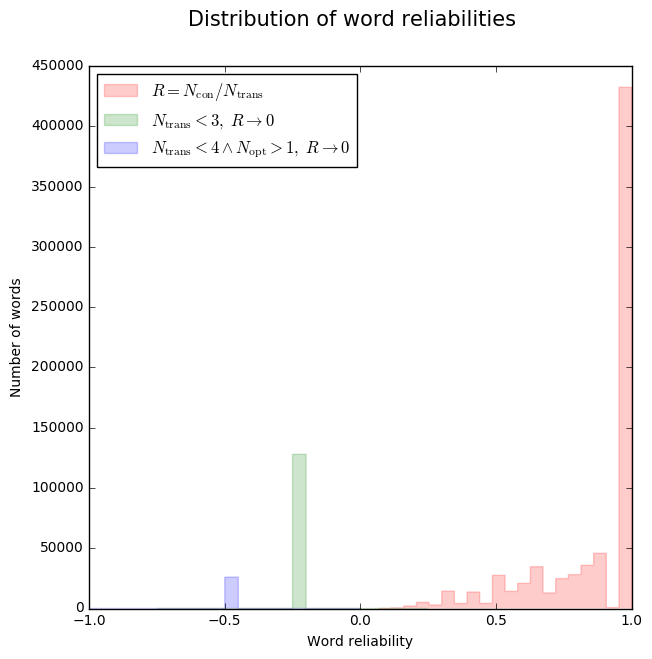

In [22]:
gc.collect()
allWordReliabilities = np.array(list(itertools.chain(*[wordData['wordReliabilities'] for wordData in lineGroupedTranscriptionLineDetails["words"]])))
mplplot.figure(figsize=(7,7))
mplplot.suptitle('Distribution of word reliabilities', fontsize=15)
mplplot.xlabel('Word reliability')
mplplot.ylabel('Number of words')
allWordReliabilityAxis = mplplot.hist(allWordReliabilities[allWordReliabilities > 0], bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r', label=r"$R = N_{\rm con}/N_{\rm trans}$")
allWordReliabilityAxis = mplplot.hist(allWordReliabilities[np.logical_and(allWordReliabilities > -0.3, allWordReliabilities < 0.0)], bins=20, histtype='step', alpha=0.2, fill=True, fc='g', ec='g', label=r"$N_{\rm trans} < 3,\;R\rightarrow 0$")
allWordReliabilityAxis = mplplot.hist(allWordReliabilities[np.logical_and(allWordReliabilities > -0.6, allWordReliabilities < -0.3)], bins=20, histtype='step', alpha=0.2, fill=True, fc='b', ec='b', label=r"$N_{\rm trans} < 4 \wedge N_{\rm opt} > 1,\;R\rightarrow 0$")
handles, labels = mplplot.gcf().gca().get_legend_handles_labels()
mplplot.legend(handles[:], labels[:], loc='upper left')
mplplot.show()

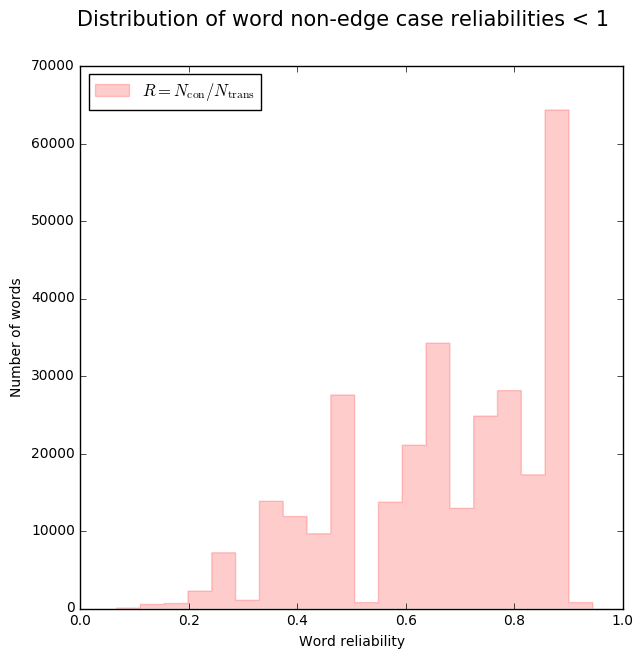

In [23]:
gc.collect()
allWordReliabilities = np.array(list(itertools.chain(*[wordData['wordReliabilities'] for wordData in lineGroupedTranscriptionLineDetails["words"]])))
mplplot.figure(figsize=(7,7))
mplplot.suptitle('Distribution of word non-edge case reliabilities < 1', fontsize=15)
mplplot.xlabel('Word reliability')
mplplot.ylabel('Number of words')
allWordReliabilityAxis = mplplot.hist(allWordReliabilities[np.logical_and(allWordReliabilities > 0, allWordReliabilities < 1)], bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r', label=r"$R = N_{\rm con}/N_{\rm trans}$")
handles, labels = mplplot.gcf().gca().get_legend_handles_labels()
mplplot.legend(handles[:], labels[:], loc='upper left')
mplplot.show()

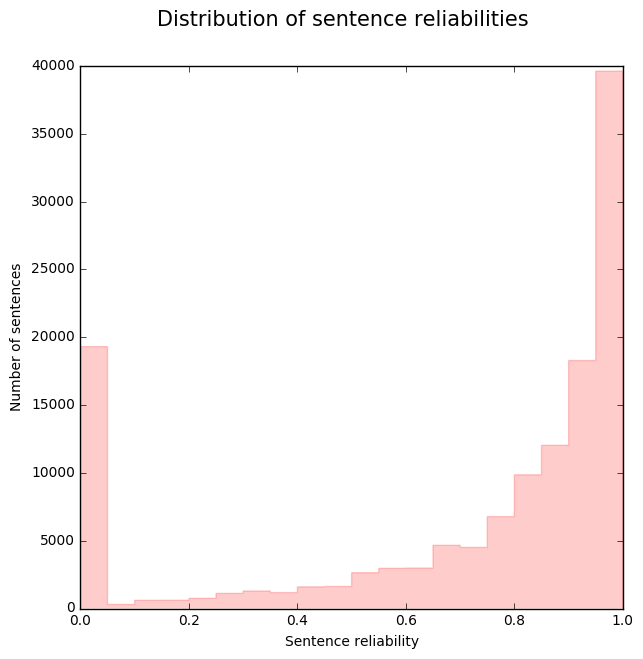

In [24]:
gc.collect()
allSentenceReliabilities = np.array([wordData['reliability'] for wordData in lineGroupedTranscriptionLineDetails["words"]])
mplplot.figure(figsize=(7,7))
mplplot.suptitle('Distribution of sentence reliabilities', fontsize=15)
mplplot.xlabel('Sentence reliability')
mplplot.ylabel('Number of sentences')
allSentenceReliabilityAxis = mplplot.hist(allSentenceReliabilities, bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r')

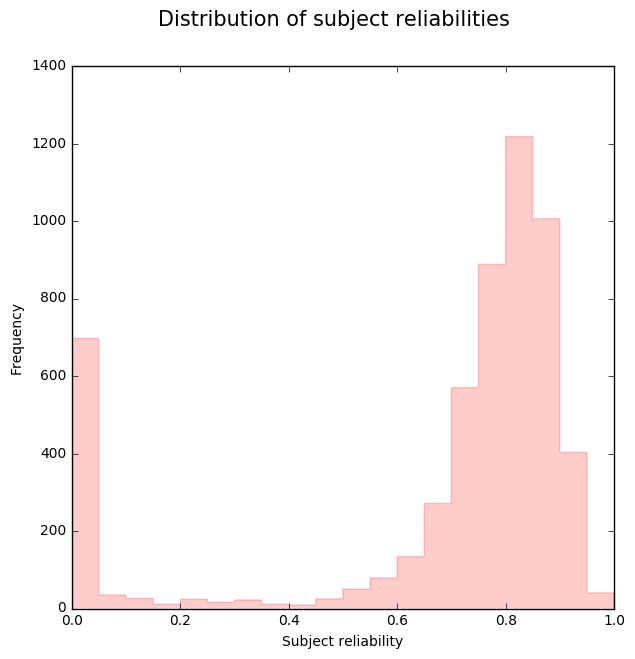

In [25]:
gc.collect()
subjectGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails.groupby(level=0).aggregate({'words' : lambda sentences : np.sum([sentence['reliability'] for sentence in sentences])/float(len(sentences))})
mplplot.figure(figsize=(7,7))
mplplot.suptitle('Distribution of subject reliabilities', fontsize=15)
mplplot.xlabel('Subject reliability')
mplplot.ylabel('Number of subjects')
allSentenceReliabilityAxis = subjectGroupedTranscriptionLineDetails['words'].plot.hist(bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r')

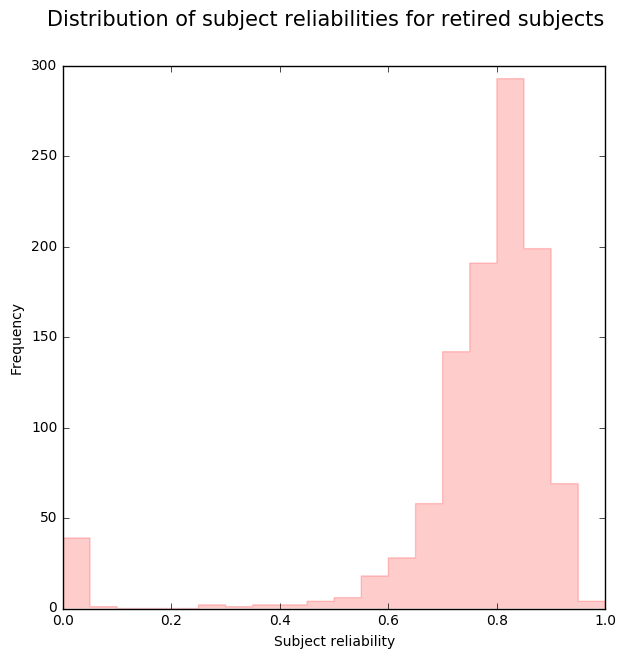

In [26]:
gc.collect()
retiredSubjectGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails[lineGroupedTranscriptionLineDetails['retired']].groupby(level=0).aggregate({'words' : lambda sentences : np.sum([sentence['reliability'] for sentence in sentences])/float(len(sentences))})
mplplot.figure(figsize=(7,7))
mplplot.suptitle('Distribution of subject reliabilities for retired subjects', fontsize=15)
mplplot.xlabel('Subject reliability')
mplplot.ylabel('Number of subjects')
allSentenceReliabilityAxis = retiredSubjectGroupedTranscriptionLineDetails['words'].plot.hist(bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r')

## Store consensus data in MySQL database

The consensus data for the telegrams are stored in a MySQL database that was created using the following commands:

```sql
CREATE DATABASE dcwConsensus;

USE dcwConsensus;

CREATE TABLE Subjects (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
zooniverseId INT NOT NULL,
huntingtonId CHAR(20) NOT NULL,
url VARCHAR(500) NOT NULL,
subjectReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE SubjectLines (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
subjectId INT NOT NULL,
bestLineIndex INT NOT NULL,
meanX1 DECIMAL(7,3) NOT NULL,
meanX2 DECIMAL(7,3) NOT NULL,
meanY1 DECIMAL(7,3) NOT NULL,
meanY2 DECIMAL(7,3) NOT NULL,
lineReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE LineWords (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
lineId INT NOT NULL,
wordText VARCHAR(100) CHARACTER SET utf16,
position INT NOT NULL,
rank INT NOT NULL,
transcriptionIndex INT NOT NULL,
spanStart INT NOT NULL,
spanEnd INT NOT NULL,
wordReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE MetaTags (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
bestLineIndex INT NOT NULL,
transcriptionIndex INT NOT NULL,
state ENUM('unclear', 'insertion', 'deletion') NOT NULL,
start INT NOT NULL,
end INT NOT NULL,
UNIQUE KEY(bestLineIndex, transcriptionIndex, state, start)
);
```

In [29]:
sys.path.append('/Library/Python/2.7/site-packages')
import mysql.connector
#testSubjectData = lineGroupedTranscriptionLineDetails.iloc[0]
connection = mysql.connector.connect(user=os.environ['DCW_MYSQL_USER'], password=os.environ['DCW_MYSQL_PASS'],
                              host=os.environ['DCW_MYSQL_HOST'],
                              database='dcwConsensus')

cursor = connection.cursor()
sentence = ''
try:
    subjectInsertQuery = ("INSERT INTO Subjects "
                         "(zooniverseId, huntingtonId, url, subjectReliability) "
                         "VALUES (%s, %s, %s, %s)")
        
    lineInsertQuery = ("INSERT INTO SubjectLines "
                      "(subjectId, bestLineIndex, meanX1, meanX2, meanY1, meanY2, lineReliability) "
                      "VALUES (%s, %s, %s, %s, %s, %s, %s)")

    wordInsertQuery = ("INSERT INTO LineWords "
                      "(lineId, wordText, position, rank, transcriptionIndex, spanStart, spanEnd, wordReliability) "
                      "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)")
    
    metaTagInsertQuery = ("INSERT INTO MetaTags "
                      "(bestLineIndex, transcriptionIndex, state, start, end) "
                      "VALUES (%s, %s, %s, %s, %s)")
    
    currentSubject = -1
    subjectId = None
    
    # Keep a record of the saved metatags
    savedMetaData = {}
    
    # Loop over aggregated lines in consensus data 
    for index, row in lineGroupedTranscriptionLineDetails.iterrows() :
        if index in subjectGroupedTranscriptionLineDetails.index.values :
            if index != currentSubject :
                # If the subject has changed, insert a new subject entry
                subjectData = (int(index), row['huntington_id'], row['url'], float(subjectGroupedTranscriptionLineDetails.loc[int(index)]['words']))
                cursor.execute(subjectInsertQuery, subjectData)
                subjectId = cursor.lastrowid
                currentSubject = index
        else :
            print ('Subject index not found for: ', row)
        # Insert the aggregated line data
        bestLineIndex = int(row['bestLineIndex'])
        lineData = (subjectId, int(bestLineIndex), row['x1'], row['x2'], row['y1'], row['y2'], row['words']['reliability'])
        cursor.execute(lineInsertQuery, lineData)
        lineId = cursor.lastrowid
                
        # Loop over word positions in the aggregated line
        for wordPosition, wordList in enumerate(row['words']['words']) :
            # Loop over words at each position
            for wordRank, word in enumerate(wordList) :
                sentence = word.sentence
                wordTranscriptionIndex = int(row['transcriptionIndex'][wordRank])
                wordData = (lineId, word.word[0:99], wordPosition, wordRank, int(wordTranscriptionIndex), word.span[0], word.span[1], 0.0)
                cursor.execute(wordInsertQuery, wordData)
                wordId = cursor.lastrowid
                # only insert data for each set of metatags once
                if len(word.tagStates) > 0 and (wordTranscriptionIndex not in savedMetaData or bestLineIndex not in savedMetaData[wordTranscriptionIndex]):
                    if wordTranscriptionIndex in savedMetaData :
                        savedMetaData[wordTranscriptionIndex].append(bestLineIndex)
                    else :
                        savedMetaData.update({wordTranscriptionIndex : [bestLineIndex]})
                    for tag, spans in word.tagStates.items() :
                        for span in spans :
                            metaTagData = (int(bestLineIndex), int(wordTranscriptionIndex), tag, span[0], span[1])
                            cursor.execute(metaTagInsertQuery, metaTagData)
                        
except mysql.connector.Error as err:
    print("Failed INSERT: {0}, {1}".format(sentence, err))
    
connection.commit()

cursor.close()
connection.close()